In [1]:
library(data.table)
library(tidyverse)
library(corrplot)
#library(broom)
library(caret)
library(lightgbm)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

corrplot 0.84 loaded

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: R6


Attaching package: ‘lightgbm’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month,

In [2]:
df <- fread('~/hakmar_tidy_features.csv')

In [3]:
options(scipen=999)

In [5]:
dff <- df %>% filter(tarih<'2020-05-01',satis>0) %>% mutate(satis=round(satis,2))

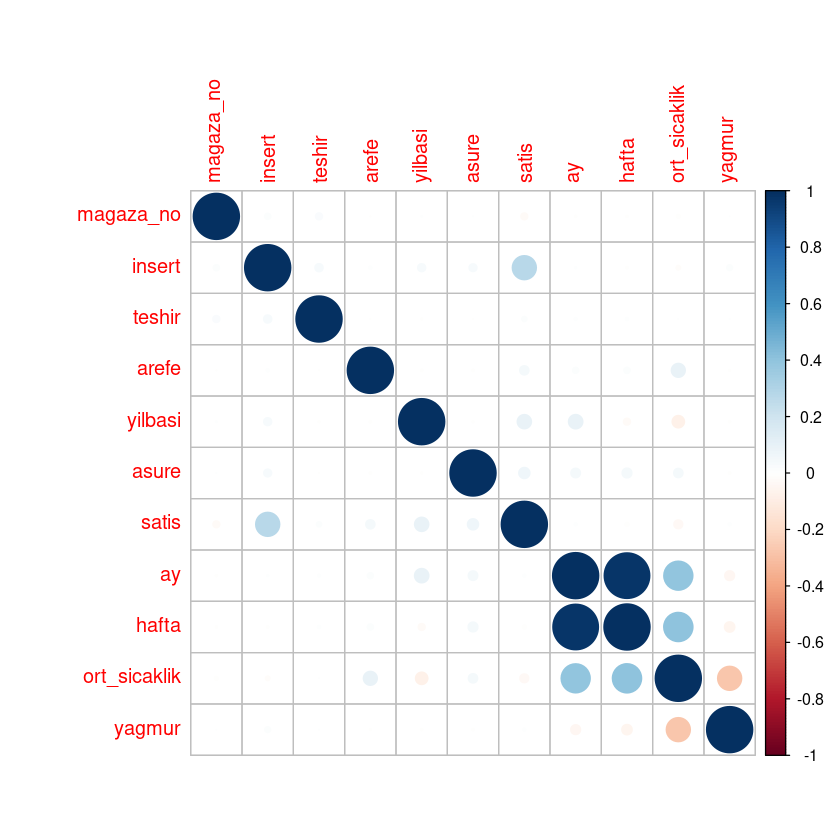

In [6]:
dff %>%
select(-c(tarih,stok_kodu,hafta_gun))%>%
cor %>%
corrplot

Birbiri üzerinden türetilmiş değişkenler dışında (ve insert~satış dışında) diğerleri arasında korelasyon yok, en düşük korelasyonu olan değişkenlerden başlayarak modeller kuracağım.

# Model

In [7]:
dff %>%
select(-c(hafta_gun,stok_kodu,tarih)) %>%
cor %>%
abs %>% 
data.table(keep.rownames = T) %>%
melt %>%
arrange(value) %>%
head(50) %>%
mutate(index=rep(1:2,n()/2)) %>% 
filter(index==1) %>% 
select(-index) %>% 
rename(var1=rn,var2=variable,korelasyon=value)

Warning message in melt.data.table(.):
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [rn, ...]. Consider providing at least one of 'id' or 'measure' vars in future.”


var1,var2,korelasyon
<chr>,<fct>,<dbl>
ort_sicaklik,teshir,0.0002875849
yagmur,magaza_no,0.0003455072
arefe,teshir,0.0003884195
asure,teshir,0.0005554811
yagmur,teshir,0.0006224417
asure,magaza_no,0.0007698285
arefe,magaza_no,0.0008931726
yilbasi,magaza_no,0.0020810914
yagmur,arefe,0.0026379862


In [8]:
formula1 <- 'satis ~ ort_sicaklik + as.factor(yagmur) + as.factor(magaza_no) + as.factor(arefe) + as.factor(asure) + as.factor(teshir) + as.factor(yilbasi) + as.factor(insert) + as.factor(ay) + as.factor(stok_kodu) '
formula1 <- as.formula(formula1)
formula1

satis ~ ort_sicaklik + as.factor(yagmur) + as.factor(magaza_no) + 
    as.factor(arefe) + as.factor(asure) + as.factor(teshir) + 
    as.factor(yilbasi) + as.factor(insert) + as.factor(ay) + 
    as.factor(stok_kodu)

# Yıllara göre paket ve açık ürün satışı

In [9]:
x2017 <- fread('~/hakmar/2017.csv',dec = '.')
x2018 <- fread('~/hakmar/2018.csv',dec = '.')
x2019 <- fread('~/hakmar/2019.csv',dec = '.')
x2020 <- fread('~/hakmar/2020.csv',dec = '.')
x2021 <- fread('~/hakmar/2021.csv',dec = '.')
colname <- fread('~//hakmar_fulldata.csv',nrows = 1)
data2 <- list(x2017,x2018,x2019,x2020,x2021) %>% rbindlist
colnames(data2) <- names(colname)[2:11]
ozel_gun_anlam <- fread('~/hakmar/Ozel_gunler.csv')
stok <- fread('~//hakmar/Stoklar.csv') %>% mutate(stok_kodu=V1,urun=paste(V17,V2)) %>% select(stok_kodu,urun)

In [10]:
data2 %>%
select(tarih,ozel_gun) %>%
mutate(tarih=ymd_hms(tarih)) %>%
left_join(ozel_gun_anlam %>% filter(!grepl('yıldön',V2)),by=c('ozel_gun'='V1')) %>% 
select(tarih,V2) %>% rename(ozel_gun=V2) %>% na.omit -> ozel_gun

In [11]:
data2 %>%
select(tarih,stok_kodu,satis_miktari,ozel_gun) %>%
mutate(tarih=ymd_hms(tarih)) %>%
left_join(stok,by='stok_kodu') %>% 
mutate(tur=ifelse(grepl('ACIK',urun),'Acik (KG)','Paket (Adet)')) %>% 
select(tarih,tur,satis_miktari) %>% 
group_by(tarih,tur) %>% 
summarise(toplam_satis=sum(satis_miktari)) %>% 
ungroup %>% 
left_join(ozel_gun,by='tarih') %>% 
mutate(gun=yday(tarih),yil=year(tarih)) -> to_plot 


to_plot %>%
na.omit %>% 
left_join(ozel_gun_anlam %>%
          mutate(gun=as.factor(V2),V1=as.factor(V1))
          ,by=c('ozel_gun'='V1')) -> to_plot2


`summarise()` has grouped output by 'tarih'. You can override using the `.groups` argument.



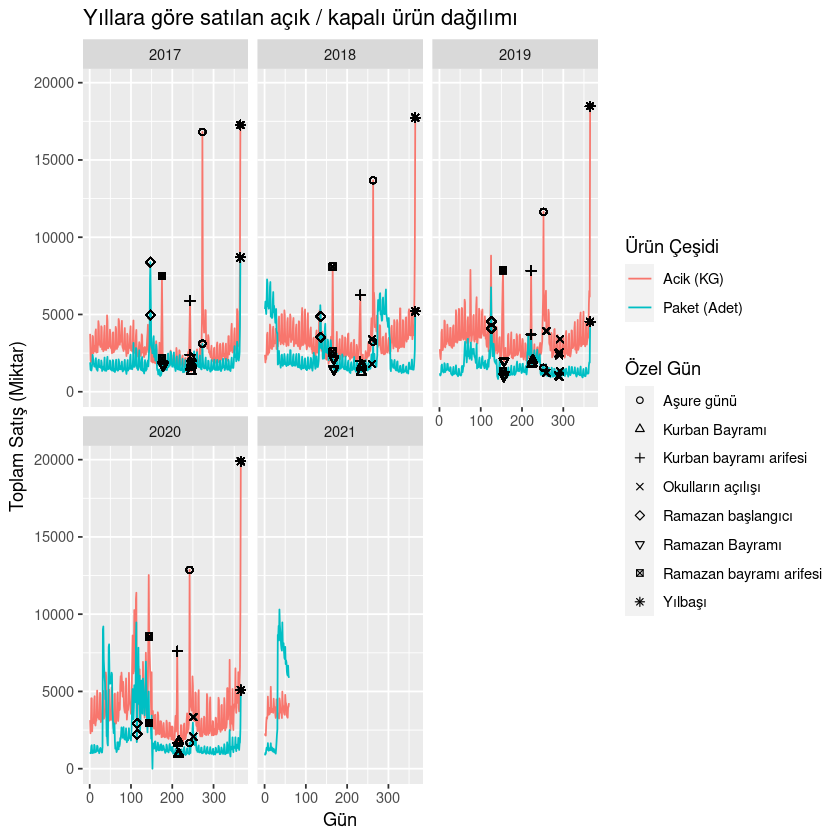

In [12]:
to_plot %>%
mutate(ozel_gun=as.factor(ozel_gun)) %>% 
ggplot(aes(x=gun,y=toplam_satis)) +
geom_line(aes(color=tur))+
geom_point(data=to_plot %>% na.omit,aes(shape=ozel_gun))+
scale_shape_manual(values = seq(1,8))+
facet_wrap(~yil)+
ylab('Toplam Satış (Miktar)')+
xlab('Gün')+
guides(color=guide_legend(title='Ürün Çeşidi'),shape=guide_legend(title='Özel Gün'))+
ggtitle('Yıllara göre satılan açık / kapalı ürün dağılımı')

In [91]:
ggsave('acikkapali.png',width = 15,height = 8)

## Ürün kategorize

In [13]:
kategorize <- function(x){
    if(grepl('ANTEP',x)) return('Antep Fistigi')
    if(grepl('BADEM',x)) return('Badem')
    if(grepl('FINDIK',x)) return('Findik')
    if(grepl('UZUM',x)) return('Uzum')
    if(grepl('LEBLEB',x)) return('Leblebi')
    if(grepl('CEVI',x)) return('Ceviz')
    if(grepl('FISTI',x)) return('Fistik')
    if(grepl('CEKIRDE',x)) return('Cekirdek')
    if(grepl('KARISI',x) | grepl('MIX',x)| grepl('KOKTEY',x)| grepl('MEYVELE',x)) return('Karisik')
    if(grepl('INCIR',x)) return('Incir')
    if(grepl('KAYIS',x)) return('Kayisi')
    if(grepl('GUN KURUS',x)) return('Gun Kurusu')
    if(grepl('NUTZZ',x)) return('Yer Fistigi')
    if(grepl('KURU',x)) return('Kurutulmus Meyve')
    if(grepl('CITLIY',x)) return('Cekirdek')
    if(grepl('HURMA',x)) return('Hurma')
    if(grepl('KAJU',x)) return('Kaju')
    if(grepl('MANGO',x)) return('Mango')
    if(grepl('BAR',x) | grepl('NESFIT',x)) return('Bar')
    if(grepl('KECI BOY',x)) return('Keci Boynuzu')
    if(grepl('MISIR',x)) return('Misir')
    if(grepl('LOKUM',x) | grepl('KOME',x)| grepl('TATLIS',x)| grepl('BALLI',x) ) return('Hazir Tatlilar')
}

In [14]:
stok  %>% mutate(kategori= apply(stok %>% select(urun),1,kategorize)) -> kategorized_urun

In [16]:
kategorized_urun %>% fwrite('~/Desktop/urun_kategorileri.csv')

In [218]:
to_plot3 %>% left_join(to_plot2,by='tarih') %>% select(tarih,kategori,ozel_gun,gun.x) %>% unique %>% rename(gun=gun.x) -> to_plot4

In [231]:
to_plot4 %>% left_join(to_plot3 %>% select(toplam_satis,tarih,kategori),by=c('tarih','kategori'))->to_plot5

`summarise()` has grouped output by 'tarih'. You can override using the `.groups` argument.



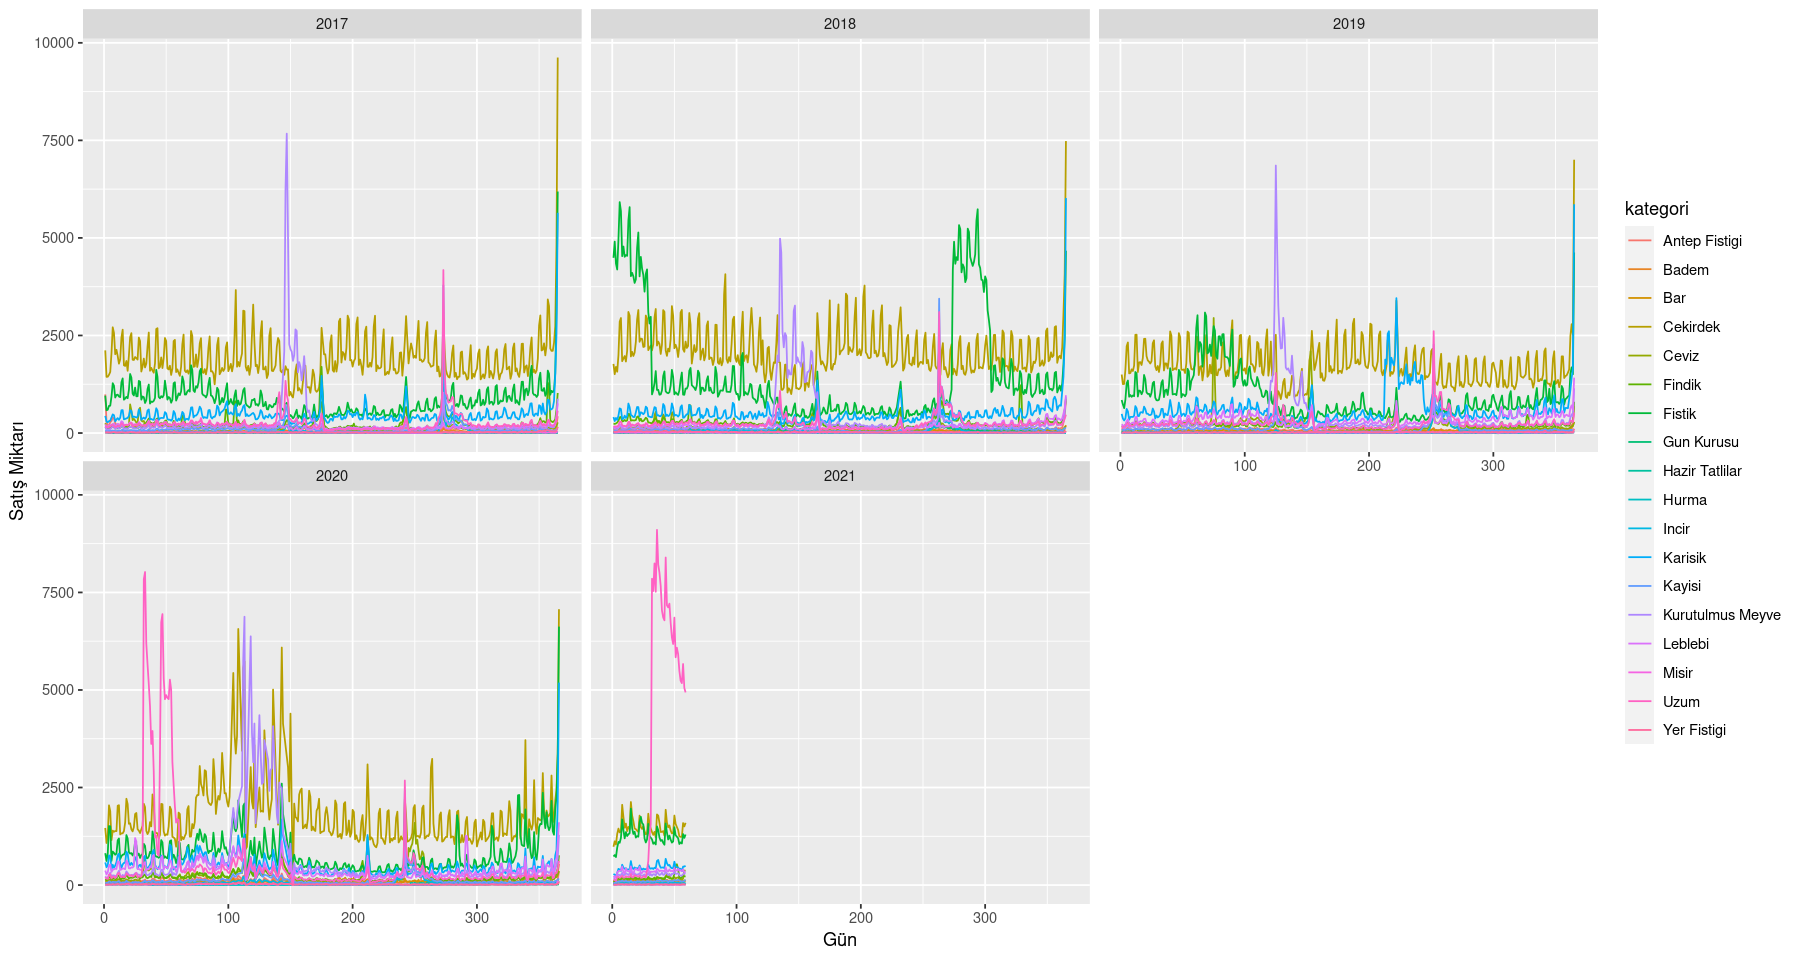

In [234]:
data2 %>%
mutate(tarih=ymd_hms(tarih)) %>% 
select(tarih,stok_kodu,satis_miktari) %>% 
left_join(kategorized_urun,by='stok_kodu') %>% 
select(-c(urun,stok_kodu)) %>% 
group_by(tarih,kategori) %>% 
summarise(toplam_satis=sum(satis_miktari)) %>% 
ungroup %>% 
mutate(gun=yday(tarih),yil=year(tarih)) -> to_plot3

to_plot3 %>% 
ggplot(aes(x=gun,y=toplam_satis)) +
geom_line(aes(color=kategori))+
facet_wrap(~yil)+
ylab('Satış Miktarı')+
xlab('Gün')


In [20]:
data2 %>% filter(satis_tutari<0)

tarih,magaza_no,stok_kodu,satis_miktari,satis_tutari,stok_miktari,satis_fiyati,insert,teshir,ozel_gun
<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
2017-01-02 00:00:00.000,3,4876,-1.000,-16.20370370370369883517,15.00,14.8148,0,0,0
2017-01-06 00:00:00.000,6,514135,-3.000,-2.77777777777777989954,16.00,0.9259,0,0,0
2017-01-12 00:00:00.000,6,602283,-1.000,-8.28703703703703986605,4.00,9.2593,0,0,0
2017-01-13 00:00:00.000,18,11094,-0.330,-4.25000000000000000000,18.95,12.8704,0,0,0
2017-01-13 00:00:00.000,18,5323,-0.250,-2.30555555555555979907,4.39,11.9444,0,0,0
2017-01-19 00:00:00.000,10,604469,-0.125,-5.77777777777772971746,10.31,55.4630,0,0,0
2017-01-29 00:00:00.000,12,505141,-1.000,-5.50925925925926041060,4.00,5.5093,0,0,0
2017-02-05 00:00:00.000,3,107114,-0.188,-2.07407407407408017619,18.08,11.0185,0,0,0
2017-02-08 00:00:00.000,4,5304,-0.259,-3.33333333333330017467,91.37,12.8704,0,0,0


In [235]:
ggsave('urun_kategorized.png',width = 15,height = 8)

## Yeni veri kayıt

In [254]:
df <- fread('~/hakmar_tidy_features.csv') %>% select(tarih,ort_sicaklik,yagmur) %>% unique

In [377]:
data2 %>%
mutate(tarih=ymd_hms(tarih)) %>%
left_join(kategorized_urun %>% select(-urun),by='stok_kodu') %>% 
mutate(arife=ifelse(ozel_gun==2 | ozel_gun==1,1,0),yilbasi=ifelse(ozel_gun==6,1,0),asure=ifelse(ozel_gun==4,1,0)) %>% 
select(-c(stok_kodu,ozel_gun)) %>% 
group_by(magaza_no,tarih,kategori,arife,yilbasi,asure) %>%
summarise(ciro = sum(satis_tutari)) %>%
filter(ciro>0) %>% 
ungroup %>% 
mutate(ciro=round(ciro,2)) %>% 
left_join(df %>% unique(by='tarih'),by='tarih') %>%
mutate(hafta_gun=wday(tarih),hafta_yil=isoweek(tarih),ay=month(tarih)) %>% 
as.data.table -> manipulated


`summarise()` has grouped output by 'magaza_no', 'tarih', 'kategori', 'arife', 'yilbasi'. You can override using the `.groups` argument.



In [487]:
onehot <- dummyVars('~.',manipulated %>% mutate(magaza_no=as.factor(magaza_no)))
new <- data.table(predict(onehot,manipulated %>% mutate(magaza_no=as.factor(magaza_no))))

In [488]:
new -> manipulated2

In [489]:
normalit<-function(m){
   (m - min(m))/(max(m)-min(m))
 }

In [491]:
manipulated2 %>%
select(-tarih) %>%
mutate(sicaklik_norm=normalit(ort_sicaklik),
                   ay_norm=normalit(ay),
                   hafta_norm=normalit(hafta_yil),
                   gun_norm=normalit(hafta_gun))%>%
select(-c(ort_sicaklik,ay,hafta_yil,hafta_gun)) -> data_tomodel

In [2]:
data_tomodel <- fread('~/hakmar/for_keras_hakmar.csv')

In [3]:
traindex <- sample(1:nrow(data_tomodel),nrow(data_tomodel)*0.7)
train <- data_tomodel[traindex]
test <- data_tomodel[-traindex]
train_x <- train %>% select(-ciro) %>% as.matrix
train_y <- train[,ciro] %>% as.matrix
test_x <- test %>% select(-ciro) %>% as.matrix
test_y <- test[,ciro] %>% as.matrix

In [4]:
library(keras)

In [10]:
networkz <- keras_model_sequential() %>%
layer_dense(units = 310,input_shape = ncol(train_x),activation = 'relu') %>%
layer_dense(units = 300,activation = 'relu') %>% 
layer_dense(units = 280,activation = 'relu') %>% 
layer_dense(units = 260,activation = 'relu') %>% 
layer_dense(units = 250,activation = 'relu') %>% 
layer_dense(units = 200,activation = 'relu') %>% 
layer_dense(units = 180,activation = 'relu') %>%
layer_dense(units = 130,activation = 'relu') %>% 
layer_dense(units = 100,activation = 'relu') %>%
layer_dense(units = 70,activation = 'relu') %>% 
layer_dense(units = 40,activation = 'relu') %>%
layer_dense(units = 20,activation = 'relu') %>% 
layer_dense(units = 10,activation = 'relu') %>%
layer_dense(units = 8,activation = 'relu') %>%
layer_dense(units = 5,activation = 'relu') %>% 
layer_dense(units = 1,activation = 'linear')

In [11]:
networkz %>% 
compile(optimizer='rmsprop',loss='mse',metrics='mean_absolute_error')

In [12]:
networkz %>% summary

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_15 (Dense)                    (None, 310)                     16740       
________________________________________________________________________________
dense_14 (Dense)                    (None, 300)                     93300       
________________________________________________________________________________
dense_13 (Dense)                    (None, 280)                     84280       
________________________________________________________________________________
dense_12 (Dense)                    (None, 260)                     73060       
________________________________________________________________________________
dense_11 (Dense)                    (None, 250)                     65250       
________________________________________________________________________________
dense_10

In [25]:
networkz %>% fit(train_x,train_y,epochs = 100,validation_data = )

In [26]:
networkz %>% predict(test_x) -> preds

In [27]:
preds %>% cbind(test_y) %>% as.data.table %>% rename(pred=V1,obs=V2) %>% defaultSummary

RMSE    Rsquared         MAE 
222.4423519   0.6473512 104.5784763